In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from yellowbrick.model_selection import ValidationCurve

In [20]:
from generated import eda

## 2.2 Preprocessing

In [21]:
# Checkpoint to reset preprocessing
df = pd.read_excel("../data/unprocessed.xlsx")
assert df.shape == (1044, 34)

As our first preprocessing step, we will change the dtype from 'object' to 'category'

In [22]:
categorical_columns = eda.categorical_columns

for col in categorical_columns:
    df[col] = df[col].astype("category")
    
df[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      1044 non-null   category
 1   sex         1044 non-null   category
 2   address     1041 non-null   category
 3   famsize     1037 non-null   category
 4   Pstatus     1034 non-null   category
 5   Mjob        1040 non-null   category
 6   Fjob        1038 non-null   category
 7   reason      1035 non-null   category
 8   guardian    1038 non-null   category
 9   schoolsup   1039 non-null   category
 10  famsup      1039 non-null   category
 11  paid        1037 non-null   category
 12  activities  1031 non-null   category
 13  nursery     1034 non-null   category
 14  higher      1039 non-null   category
 15  internet    1036 non-null   category
 16  romantic    1034 non-null   category
 17  subject     1044 non-null   category
dtypes: category(18)
memory usage: 20.9 KB


,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,subject
0,GP,F,U,GT3,A,services,services,reputation,mother,no,yes,no,yes,yes,yes,yes,no,portuguese
1,GP,M,R,GT3,T,teacher,services,other,mother,no,yes,no,yes,yes,yes,yes,yes,portuguese
2,MS,F,R,LE3,T,at_home,other,course,mother,no,no,no,yes,yes,no,yes,no,portuguese
3,GP,F,U,GT3,T,services,other,reputation,mother,no,yes,no,yes,yes,yes,yes,no,portuguese
4,GP,F,U,GT3,T,other,other,course,father,no,no,no,yes,yes,yes,yes,yes,portuguese


### Missing Values

For categorical data, we will use SimpleImputer with "most frequent" strategy

In [23]:
simple_imputer = SimpleImputer(strategy="most_frequent")

for col in categorical_columns:
    df[[col]] = simple_imputer.fit_transform(df[[col]])

For numeric variables, since there are not a lot of missing data IterativeImputer would be the best choice

In [24]:
iterative_imputer = IterativeImputer()
numeric_columns = eda.numeric_columns

for col in numeric_columns:
    df[[col]] = iterative_imputer.fit_transform(df[[col]])
    
# Check that there are no more missing values in our dataset
missing_values = df.isnull().sum()
assert len(missing_values[missing_values > 0]) == 0

### Encoding

We will use a LabelEncoder for "binary" columns

In [25]:
label_encoder = LabelEncoder()
binary_columns = [col for col in categorical_columns if len(df[df[col].notnull()][col].unique()) == 2]

for col in binary_columns:
    df[col] = label_encoder.fit_transform(df[col])
    
df[binary_columns].head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,subject
0,0,0,1,0,0,0,1,0,1,1,1,1,0,1
1,0,1,0,0,1,0,1,0,1,1,1,1,1,1
2,1,0,0,1,1,0,0,0,1,1,0,1,0,1
3,0,0,1,0,1,0,1,0,1,1,1,1,0,1
4,0,0,1,0,1,0,0,0,1,1,1,1,1,1


And OneHotEncoder for columns that have more than 2 unique values

In [26]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
nonbinary_columns = [col for col in categorical_columns if col not in binary_columns]

one_hot_encoded_data = one_hot_encoder.fit_transform(df[nonbinary_columns])
one_hot_encoded_columns = one_hot_encoder.get_feature_names_out(nonbinary_columns)

# Create a df from the encoded data and columns
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data, columns=one_hot_encoded_columns)

# Transform the original df
df = pd.concat([df.drop(columns=nonbinary_columns), one_hot_encoded_df], axis=1)

In [27]:
df.shape

(1044, 47)

We have transformed the original 4 "nonbinary" categorical columns to 17 new encoded ones

### Scaling the Data

Lets continue with scaling our data, we will use a MinMaxScaler to scale all data to a range from 0-1

In [28]:
exclude_cols = ["G1", "G2", "G3"]
scale_cols = [col for col in df.columns if col not in exclude_cols]

scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

### Splitting the Data

In [29]:
X, y = df.drop(columns=["G1", "G2", "G3"]), df["G3"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape} {y_train.shape}")
print(f"Test  shape: {X_test.shape} {y_test.shape}")

Train shape: (835, 44) (835,)
Test  shape: (209, 44) (209,)


### Feature Selection

We will use Ridge Regression model for Feature Selection and perform selection of k-best features. We will use two different score functions:
- correlation feature selection using f_regression
- mutual information feature selection (typically used in the construction of decision trees)

/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: 

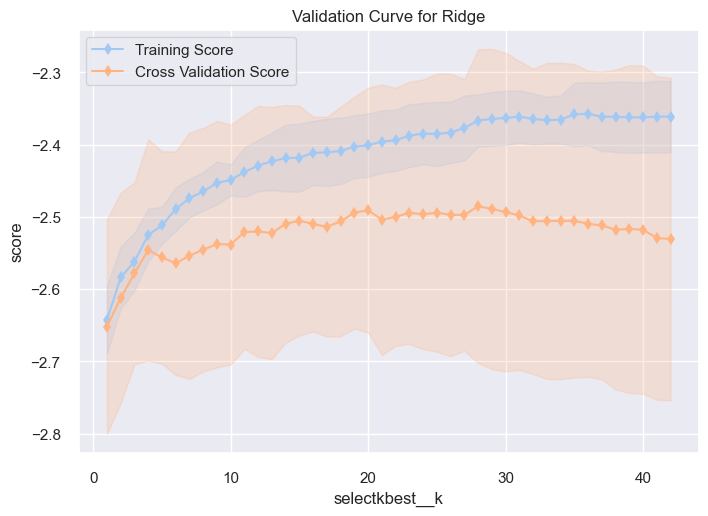

/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/marekhradil/Documents/muni/ib031-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:279: RuntimeWarning: overflow encountered in matmul
  return X

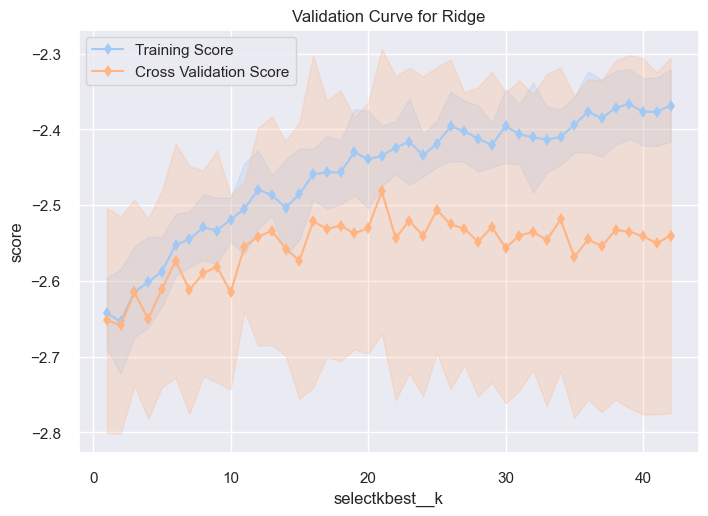

In [30]:
for score_func in [f_regression, mutual_info_regression]:
    
    kbest_pipeline = make_pipeline(
        SelectKBest(score_func=score_func),
        Ridge()
    )
    
    viz = ValidationCurve(
        kbest_pipeline,
        param_name="selectkbest__k",
        param_range=np.arange(1, 43),
        cv=5,
        scoring="neg_mean_absolute_error",
    )
    
    viz.fit(X_train, y_train)
    viz.show()
    plt.show()